In [1]:
import torch.nn as nn
print(nn.Module)


ModuleNotFoundError: No module named 'torch._C'

In [2]:
%pip install torch torchvision torchaudio numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# 1. Importing Necessary Libraries

In [6]:
import os
import numpy as np
import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


1-OS and NumPy: For file and numerical operations.
2-PyTorch Modules (torch, nn, optim, etc.): For building and training the neural network.
3-Scikit-learn Modules: For data splitting and evaluation metrics.
4-TensorFlow Keras: Specifically to_categorical for one-hot encoding labels.
5-Matplotlib and Seaborn: For plotting and visualizing data and results.

# 2. Defining Data Paths and Action Labels

In [7]:
# Define the data path and action labels
DATA_PATH = '../Data_MP/'  # Path to dataset
actions = [
    "can_you_help_me", "doesnt_matter", "good_bey", "i_have_to_go",
    "i_think_you_are_wrong", "sorry_cant_stay", "sorry_for_being_late",
    "speak_slowly", "thanks_for_your_concern", "wish_you_luck_in_work",
    "wish_you_good_journey", "wish_you_good_vacation", "please_quickly",
    "explain_again", "repeat_again", "free_or_busy", "happy_to_know_you",
    "i_disagree", "i_agree", "i_would_like_to_meet_you", "any_service",
    "come_quickly", "happy_new_year", "how_can_i_call_you", "wait_please",
    "lets_go_swim", "whats_your_name", "what_about_going_for_a_walk",
    "unbelievable", "can_i_take_from_your_time"
]
sequence_length = 120  # Assuming each video is 4 seconds at 30 fps


1-DATA_PATH: Specifies where the dataset is stored.
2-actions: A list of all the sign language actions (classes) that the model will recognize.
3-sequence_length: Defines the fixed length for each input sequence (e.g., number of frames).

# 3. Creating a Label Map

In [8]:
# Create a label map that assigns each action a unique index
label_map = {action: i for i, action in enumerate(actions)}


label_map: A dictionary that maps each action label to a unique integer index. This is essential for converting categorical labels into numerical form suitable for model training.

# 4. Defining a Function to Pad or Truncate Sequences

In [9]:
# Function to pad or truncate sequences
def pad_or_truncate(sequence, max_len):
    """Pad or truncate the sequence to ensure uniform length."""
    if len(sequence) < max_len:
        padding = np.zeros((max_len - sequence.shape[0], sequence.shape[1]))
        return np.vstack((sequence, padding))
    else:
        return sequence[:max_len]


Purpose: Ensures that all input sequences have the same length (sequence_length).
Padding: If a sequence is shorter than max_len, it pads the sequence with zeros.
Truncating: If a sequence is longer, it truncates it to max_len.

# 5. Loading and Preprocessing the Data

In [10]:
# Initialize empty lists to hold sequences and labels
sequences, labels = [], []

# Load all sequences and labels based on the folder names
for action in actions:
    action_path = os.path.join(DATA_PATH, action)  # Path to each action folder
    if not os.path.exists(action_path):
        print(f"Directory not found: {action_path}. Skipping this action.")
        continue

    # Iterate over all files in the action folder
    for video in os.listdir(action_path):
        if video.endswith("_sequence.npy"):  # Ensure it's a sequence file
            video_path = os.path.join(action_path, video)
            try:
                # Load the sequence and adjust its length
                sequence = np.load(video_path)
                sequence = pad_or_truncate(sequence, sequence_length)
                sequences.append(sequence)
                labels.append(label_map[action])  # Add the label based on the folder name
            except Exception as e:
                print(f"Error loading file {video_path}: {e}")

# Check if any data was loaded
if not sequences or not labels:
    print("No data loaded. Please check the dataset paths and file availability.")
    exit()

# Convert sequences and labels to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)


KeyboardInterrupt: 

Data Loading Loop:
1-Iterates through each action label.
2-Checks if the corresponding directory exists; if not, skips the action.
3-Within each action directory, it looks for files ending with _sequence.npy, which are assumed to contain the preprocessed keypoint sequences.
4-Error Handling: Catches and reports any issues while loading individual files.
5-Data Validation: Ensures that some data has been loaded; otherwise, it exits.
Conversion to NumPy Arrays:
X: Contains all the sequences.
y: One-hot encoded labels corresponding to each sequence.

# 6. Splitting the Data into Training and Testing Sets

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

1-train_test_split: Splits the dataset into training and testing subsets.
2-test_size=0.2: Allocates 20% of the data for testing and 80% for training.
3-random_state=42: Ensures reproducibility of the split.

# 7. Creating a Custom Dataset Class for PyTorch


In [ ]:
# Define a custom dataset class for PyTorch
class KeypointsToTextDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


Custom Dataset: Inherits from torch.utils.data.Dataset to handle the feature-label pairs.
Methods:
__init__: Initializes the dataset with features and labels.
__len__: Returns the total number of samples.
__getitem__: Retrieves a single sample and its label based on an index.

# 8. Creating DataLoaders for Training and Testing

In [ ]:
# Create DataLoaders for training and testing
train_dataset = KeypointsToTextDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
)
test_dataset = KeypointsToTextDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Conversion to Tensors:
1-Features: Converted to PyTorch tensors of type float32.
2-Labels: Converted to integer indices (not one-hot) for classification.
DataLoaders:
1-train_loader: Shuffles the data to ensure batches are randomized during training.
2-test_loader: Does not shuffle to maintain consistency during evaluation.
3-batch_size=8: Defines how many samples per batch to load.

# 9. Defining the Temporal Convolutional Network (TCN) Model

In [ ]:
# Define the Temporal Convolutional Network (TCN) model
class TemporalConvNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TemporalConvNet, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=2, dilation=4),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.AdaptiveAvgPool1d(1)  # Global Average Pooling to reduce sequence dimension
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # TCN expects input of shape [batch, channels, seq_len]
        x = x.permute(0, 2, 1)  # Permute to match TCN input requirements
        x = self.tcn(x)
        x = x.squeeze(-1)  # Remove the last dimension after global pooling
        output = self.fc(x)
        return output


Architecture:
1-Convolutional Layers: Three Conv1d layers with increasing dilation rates to capture temporal dependencies.
2-Activation and Normalization: Each convolution is followed by a ReLU activation and batch normalization for stability and performance.
3-Adaptive Average Pooling: Reduces the temporal dimension to 1, effectively summarizing the sequence information.
4-Fully Connected Layer (fc): Maps the extracted features to the number of classes for classification.
Forward Pass:
1-Input Shape Adjustment: PyTorch’s Conv1d expects input in [batch, channels, sequence_length], hence the permute.
2-Feature Extraction: Passes through the TCN layers.
3-Classification: The pooled features are fed into the fully connected layer to get the final output logits.

# 10. Initializing the Model, Loss Function, and Optimizer

In [ ]:
# Define model parameters
input_dim = 258  # Number of features per frame
hidden_dim = 512  # Hidden layer size
num_classes = len(actions)  # Number of unique actions (classes)

# Initialize the model
model = TemporalConvNet(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Model Parameters:
1-input_dim: Number of features in each frame (e.g., keypoints).
2-hidden_dim: Number of filters in the convolutional layers.
3-num_classes: Total number of action classes.
Model Initialization:
1-TemporalConvNet: Instantiates the model with the specified parameters.
2-Device Configuration: Utilizes GPU (cuda) if available for faster computation.
Loss Function:
1-CrossEntropyLoss: Suitable for multi-class classification tasks.
Optimizer:
Adam: An adaptive learning rate optimizer, set with a learning rate of 0.001.

# 11. Defining the Training Function

In [ ]:
# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')


train_model: Function to handle the training loop.
Training Mode: Sets the model to training mode using model.train().
Epoch Loop: Iterates over the specified number of epochs.
Batch Processing:
1-Data Transfer: Moves inputs and labels to the configured device (CPU/GPU).
2-Zero Gradients: Clears previous gradients to prevent accumulation.
3-Forward Pass: Computes the model's predictions.
4-Loss Calculation: Measures the discrepancy between predictions and true labels.
5-Backward Pass: Computes gradients via backpropagation.
6-Optimizer Step: Updates model parameters based on gradients.
7-Loss Tracking: Accumulates and prints the average loss per epoch for monitoring.


# 12. Training the Model

In [ ]:
# Train the model
train_model(model, train_loader, criterion, optimizer)


Epoch 1/30, Loss: 1.0308
Epoch 2/30, Loss: 0.2788
Epoch 3/30, Loss: 0.1314
Epoch 4/30, Loss: 0.1241
Epoch 5/30, Loss: 0.0448
Epoch 6/30, Loss: 0.0586
Epoch 7/30, Loss: 0.0242
Epoch 8/30, Loss: 0.0223
Epoch 9/30, Loss: 0.0799
Epoch 10/30, Loss: 0.0378
Epoch 11/30, Loss: 0.0442
Epoch 12/30, Loss: 0.0466
Epoch 13/30, Loss: 0.0291
Epoch 14/30, Loss: 0.0199
Epoch 15/30, Loss: 0.0065
Epoch 16/30, Loss: 0.0100
Epoch 17/30, Loss: 0.0142
Epoch 18/30, Loss: 0.0111
Epoch 19/30, Loss: 0.0206
Epoch 20/30, Loss: 0.0776
Epoch 21/30, Loss: 0.0214
Epoch 22/30, Loss: 0.0307
Epoch 23/30, Loss: 0.0085
Epoch 24/30, Loss: 0.0059
Epoch 25/30, Loss: 0.0097
Epoch 26/30, Loss: 0.0105
Epoch 27/30, Loss: 0.0547
Epoch 28/30, Loss: 0.0228
Epoch 29/30, Loss: 0.0151
Epoch 30/30, Loss: 0.0207


1-Invocation: Calls the train_model function with the model, training data loader, loss function, and optimizer.
2-Outcome: The model undergoes 30 epochs of training, with loss printed after each epoch.

# 13. Defining the Evaluation Function with Confusion Matrix Plotting

Accuracy: 0.9754
Classification Report:
                              precision    recall  f1-score   support

            can_you_help_me       1.00      1.00      1.00        21
              doesnt_matter       0.76      1.00      0.87        26
                   good_bey       1.00      0.95      0.97        20
               i_have_to_go       1.00      0.73      0.84        26
      i_think_you_are_wrong       0.93      1.00      0.96        25
            sorry_cant_stay       1.00      0.92      0.96        26
       sorry_for_being_late       1.00      1.00      1.00        16
               speak_slowly       0.92      0.96      0.94        23
    thanks_for_your_concern       1.00      1.00      1.00        18
      wish_you_luck_in_work       1.00      1.00      1.00        12
      wish_you_good_journey       1.00      1.00      1.00        25
     wish_you_good_vacation       1.00      1.00      1.00        23
             please_quickly       1.00      0.89      0.94   

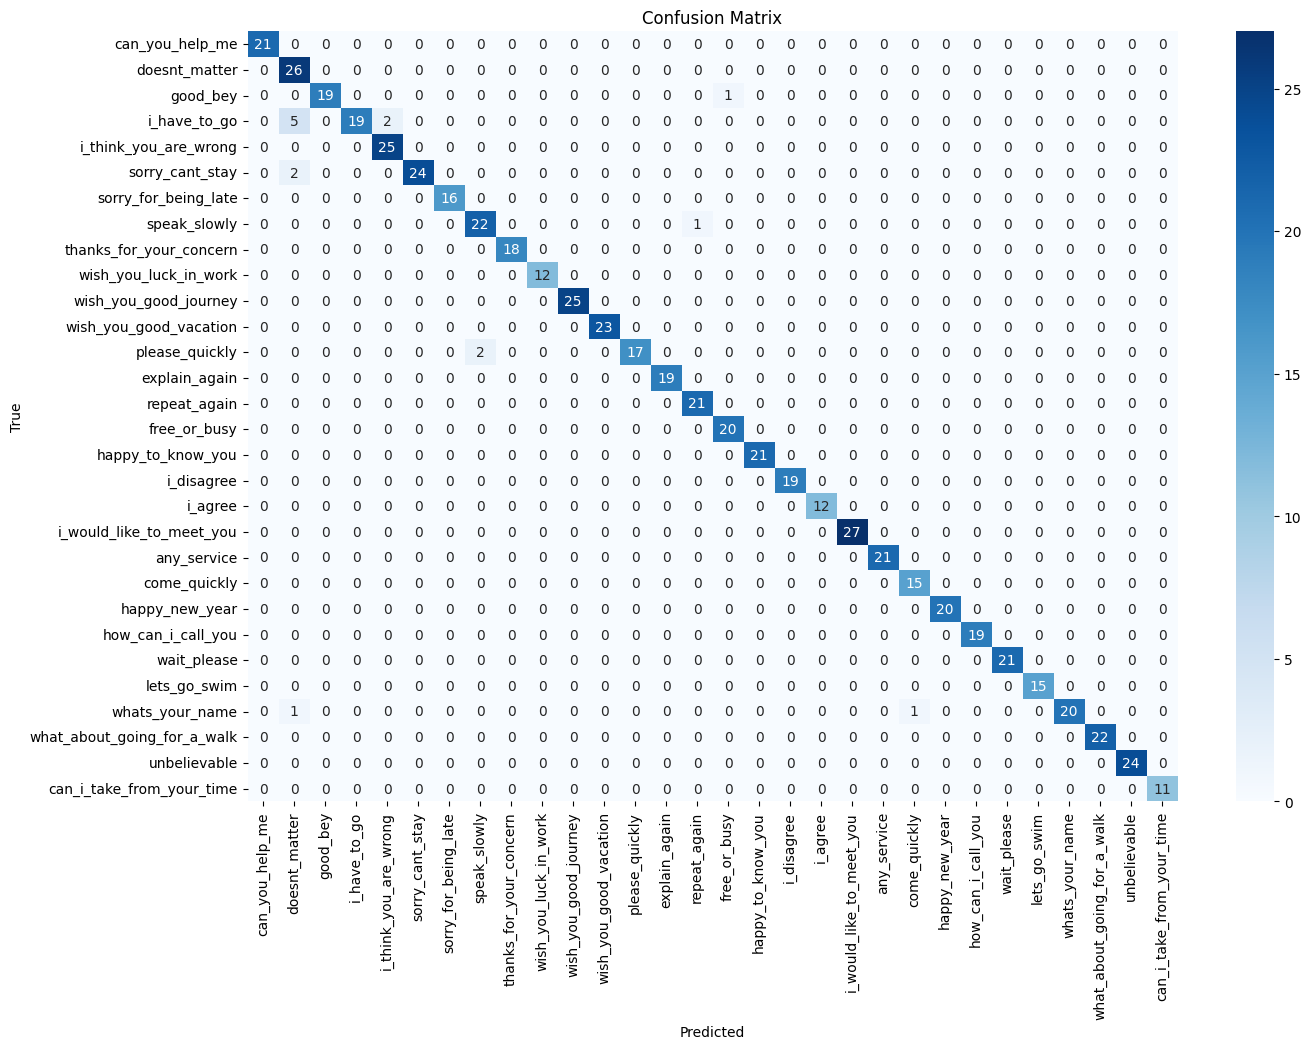

In [ ]:
# Evaluation function with confusion matrix plotting
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=actions)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", class_report)

    # Plotting the confusion matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
evaluate_model(model, test_loader)


evaluate_model: Function to assess the model's performance on the test dataset.
Evaluation Mode: Sets the model to evaluation mode using model.eval(), which disables dropout and batch normalization layers' training behavior.
No Gradient Calculation: Wraps evaluation in torch.no_grad() to save memory and computation.
Prediction Collection:
outputs.argmax(dim=1): Determines the predicted class by selecting the class with the highest logit.
Accumulates Predictions and True Labels: Stores them for metric calculations.
Metrics Computation:
accuracy_score: Overall accuracy.
classification_report: Detailed precision, recall, and F1-score per class.
confusion_matrix: Matrix showing correct and incorrect predictions for each class.
Visualization: Uses Seaborn's heatmap to plot the confusion matrix for better interpretability.

# summary of work flow

1-Import Libraries: Set up the environment with necessary packages.
2-Define Data Parameters: Specify data paths, labels, and sequence lengths.
3-Label Mapping: Convert categorical labels to numerical indices.
4-Data Loading and Preprocessing: Load sequences, handle varying lengths, and encode labels.
5-Data Splitting: Divide the dataset into training and testing subsets.
6-Dataset and DataLoader Creation: Facilitate efficient data batching and loading.
7-Model Definition: Build a Temporal Convolutional Network tailored for sequence classification.
8-Model Initialization: Set up the model, loss function, and optimizer.
9-Training: Optimize the model parameters through multiple epochs.
10-Evaluation: Assess model performance and visualize results.
